# **1η εργαστηριακή άσκηση στα Νευρωνικά Δίκτυα - Μέρος 1. UCI dataset**


**Πάλμος Στέφανος el18185**

**Ντάγκας Παναγιώτης el18018**

**Νικόλαρος Ανδρέας el18401** 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import time
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
import seaborn as sns
# φέρνουμε τις γνωστές μας κλάσεις για preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler # φέρνουμε τον StandarScaler ως transformer που έχει .transform kai ΄όχι ως scale()
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

import time



In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = ""
        else:
            stats_text = ""
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## **Εισαγωγή**
* Το dataset που μας δόθηκε έχει χρησιμοποιηθεί για την εκπαίδευση ενός νευρωνικού δικτύου, αναγνωρίζει οχήματα 4 κατηγοριών. Περιέχει τιμές χαρακτηριστικών σιλουέτας διαφόρων οχημάτων μέσω φωτογραφιών, οι οποίες έχουν τραβηχτεί από διάφορες γωνίες και έχουν υποστεί μια αρχική επεξεργασία.
* Δεν χρειάστηκαν μετατροπές των αρχείων.
* Συνολικά έχουμε 846 δείγματα, 18 χαρακτηριστικά, τα οποία είναι:
1)COMPACTNESS 2)CIRCULARITY 3)DISTANCE CIRCULARITY 4)RADIUS RATIO 5)PR.AXIS ASPECT RATIO 6)MAX.LENGTH ASPECT RATIO 7)SCATTER RATIO 8)ELONGATEDNESS 9)PR.AXIS RECTANGULARITY 10)MAX.LENGTH RECTANGULARITY 11)SCALED VARIANCE ALONG MAJOR AXIS 12)SCALED VARIANCE ALONG MINOR AXIS 13)SCALED RADIUS OF GYRATION 14)SKEWNESS ABOUT MAJOR AXIS 15)SKEWNESS ABOUT MINOR AXIS
16)KURTOSIS ABOUT MINOR AXIS 17)KURTOSIS ABOUT MAJOR AXIS 18)HOLLOWS RATIO
* Δεν υπάρχει ούτε αρίθμηση γραμμών ούτε επικεφαλίδες
* Οι ετικέτες των κλάσεων είναι bus, opel, van, saab και είναι στην 19η κολώνα
* Δεν υπάρχουν απουσιάζουσες τιμές
* Το dataset είναι σχετικά ισορροπημένο διότι το ποσοστό των κλάσεων πλησιάζει περίπου το 25% (έχουμε 4 κλάσεις).






In [ ]:
df1 = pd.read_csv('xaa.dat', delim_whitespace=True, header = None, engine='python')
df2 = pd.read_csv('xab.dat', delim_whitespace=True, header = None, engine='python')
df3 = pd.read_csv('xac.dat', delim_whitespace=True, header = None, engine='python')
df4 = pd.read_csv('xad.dat', delim_whitespace=True, header = None, engine='python')
df5 = pd.read_csv('xae.dat', delim_whitespace=True, header = None, engine='python')
df6 = pd.read_csv('xaf.dat', delim_whitespace=True, header = None, engine='python')
df7 = pd.read_csv('xag.dat', delim_whitespace=True, header = None, engine='python')
df8 = pd.read_csv('xah.dat', delim_whitespace=True, header = None, engine='python')
df9 = pd.read_csv('xai.dat', delim_whitespace=True, header = None, engine='python')


df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9], axis=0)
df.index = pd.RangeIndex(len(df.index))
print(df.head())
data = np.array(df)
y_df = data[:,18]
print("\nNaN in dataset:",np.sum(np.sum(df.isna())))
count_van = np.sum([y_df == "van"])
count_opel = np.sum([y_df == "opel"])
count_saab = np.sum([y_df == "saab"])
count_bus = np.sum([y_df == "bus"])
a_priori_bus = count_bus / len(df) * 100
a_priori_van = count_van / len(df) * 100
a_priori_opel = count_opel / len(df) * 100
a_priori_saab = count_saab / len(df) * 100

print("\nDataset Balance")
print("Class_Bus percentage: ", a_priori_bus, "%")
print("Class_Van percentage: ", a_priori_van, "%")
print("Class_Saab percentage: ", a_priori_saab, "%")
print("Class_Opel percentage: ", a_priori_opel, "%")

    0   1    2    3    4   5    6   7   8    9    10   11   12   13  14  15  \
0   95  48   83  178   72  10  162  42  20  159  176  379  184   70   6  16   
1   91  41   84  141   57   9  149  45  19  143  170  330  158   72   9  14   
2  104  50  106  209   66  10  207  32  23  158  223  635  220   73  14   9   
3   93  41   82  159   63   9  144  46  19  143  160  309  127   63   6  10   
4   85  44   70  205  103  52  149  45  19  144  241  325  188  127   9  11   

    16   17    18  
0  187  197   van  
1  189  199   van  
2  188  196  saab  
3  199  207   van  
4  180  183   bus  

NaN in dataset: 0

Dataset Balance
Class_Bus percentage:  25.768321513002363 %
Class_Van percentage:  23.52245862884161 %
Class_Saab percentage:  25.65011820330969 %
Class_Opel percentage:  25.059101654846334 %


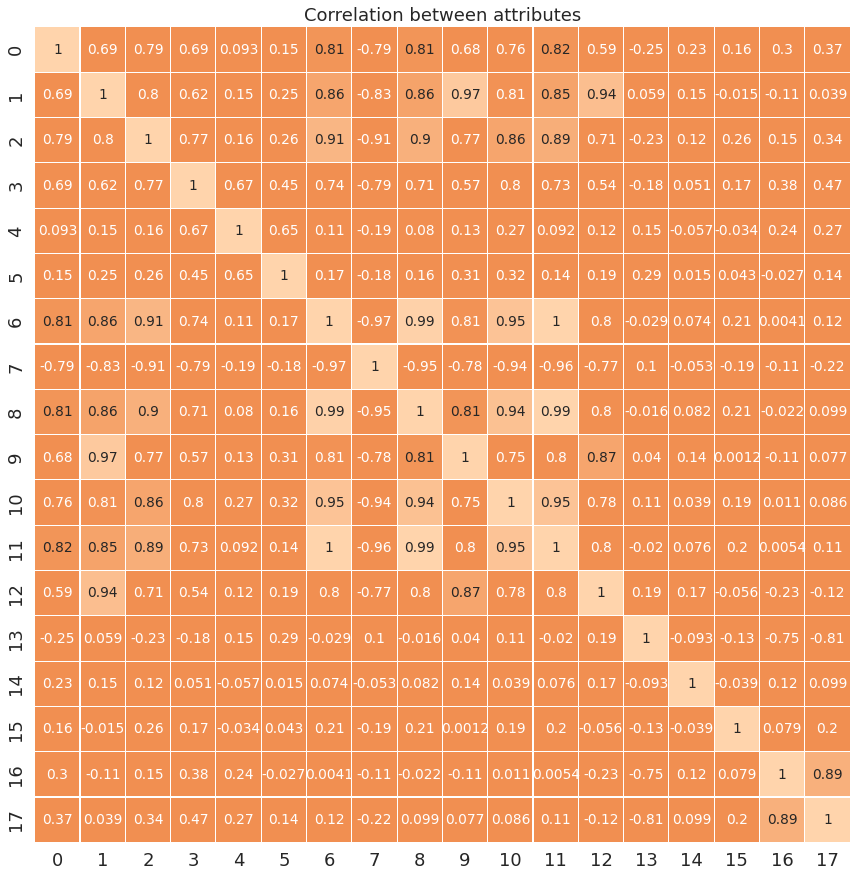

In [ ]:
cor = df.corr()

sns.set(font_scale=1.15)
fig,ax=plt.subplots(figsize=(18,15))
sns.heatmap(cor,vmin=0.8, annot=True,linewidths=0.01,center=0,linecolor="white",cbar=False,square=True)
plt.title('Correlation between attributes',fontsize=18)
ax.tick_params(labelsize=18)

Παρατηρούμε από το heat-map πως κάποια χαρακτηριστικά είναι έντονα συσχετισμένα με άλλα.

# **Προετοιμασία**
Δεν υπάρχουν απουσιάζουσες τιμές, άρα δεν χρειάζεται να κάνουμε κάτι. Αφαιρούμε την τελευταία στήλη, διότι εκεί είναι τα labels. Αντιστοιχίζουμε τα labels(Bus, Van, Saab, Opel) σε αριθμούς με αύξοντα ρυθμό αντίστοιχα(0, 1, 2, 3).  

In [ ]:
y = []
for i in range(len(y_df)):
  if (y_df[i] == "bus"):
    y.append(0)
  elif (y_df[i] == "van"):
    y.append(1)
  elif (y_df[i] == "saab"):
    y.append(2)
  else:
    y.append(3)

x = data[:,0:18]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=True)
print("\nTrainset: ", 100*X_train.shape[0]/len(x) , "% of dataset")
print("Testset: ", 100*X_test.shape[0]/len(x), "% of dataset")

y_tr_arr = np.array(y_test)
count_van = np.sum([y_tr_arr == 1])
count_opel = np.sum([y_tr_arr == 3])
count_saab = np.sum([y_tr_arr == 2])
count_bus = np.sum([y_tr_arr == 0])
a_priori_bus = count_bus / len(y_tr_arr) * 100
a_priori_van = count_van / len(y_tr_arr) * 100
a_priori_opel = count_opel / len(y_tr_arr) * 100
a_priori_saab = count_saab / len(y_tr_arr) * 100

print("\nClass Balance of Test Set")
print("Class_Bus percentage: ", a_priori_bus, "%")
print("Class_Van percentage: ", a_priori_van, "%")
print("Class_Saab percentage: ", a_priori_saab, "%")
print("Class_Opel percentage: ", a_priori_opel, "%")


Trainset:  69.97635933806147 % of dataset
Testset:  30.023640661938533 % of dataset

Class Balance of Test Set
Class_Bus percentage:  24.803149606299215 %
Class_Van percentage:  21.25984251968504 %
Class_Saab percentage:  24.015748031496063 %
Class_Opel percentage:  29.92125984251969 %


# **Ταξινόμηση**

**Ταξινομητές Dummy:**

Δοκιμάζουμε τον ταξινομητή Dummy. Θα χρησιμοποιήσουμε διάφορες τιμές της παραμέτρου strategy:



*   Uniform: τυχαία ομοιόμορφη επιλογή
*   Constant: σταθερή προκαθορισμένη επιλογή
*   Most frequent: επιλέγει την συχνότερη κατηγορία του train set
*   Stratified: επιλέγει με βάση την κατανομή των κλάσεων στο train set





In [ ]:
dummy_uniform = DummyClassifier(strategy="uniform")
dummy_const_bus = DummyClassifier(strategy="constant", constant=0)
dummy_const_van = DummyClassifier(strategy="constant", constant=1)
dummy_const_saab = DummyClassifier(strategy="constant", constant=2)
dummy_const_opel = DummyClassifier(strategy="constant", constant=3)
dummy_most_frequent = DummyClassifier(strategy="most_frequent")
dummy_stratified = DummyClassifier(strategy="stratified")

classifiers_accuracy = []
classifiers_f1_score = []

print("Dummy Classifiers Scores:")

model = dummy_uniform.fit(X_train, y_train)
predictions = dummy_uniform.predict(X_test)
classifiers_accuracy.append(dummy_uniform.score(X_test, y_test)*100)
classifiers_f1_score.append(f1_score(y_test, predictions, average = "macro")*100)
print("Uniform accuracy:", classifiers_accuracy[0], "%")
print("Uniform f1_score:", classifiers_f1_score[0], "%\n")

model = dummy_const_bus.fit(X_train, y_train)
predictions = dummy_const_bus.predict(X_test)
classifiers_accuracy.append(dummy_const_bus.score(X_test, y_test)*100)
classifiers_f1_score.append(f1_score(y_test, predictions, average = "macro")*100)
print("Const 0 accuracy:", classifiers_accuracy[1], "%")
print("Const 0 f1_score:", classifiers_f1_score[1], "%\n")

model = dummy_const_van.fit(X_train, y_train)
predictions = dummy_const_van.predict(X_test)
classifiers_accuracy.append(dummy_const_van.score(X_test, y_test)*100)
classifiers_f1_score.append(f1_score(y_test, predictions, average = "macro")*100)
print("Const 1 accuracy:", classifiers_accuracy[2], "%")
print("Const 1 f1_score:", classifiers_f1_score[2], "%\n")

model = dummy_const_saab.fit(X_train, y_train)
predictions = dummy_const_saab.predict(X_test)
classifiers_accuracy.append(dummy_const_saab.score(X_test, y_test)*100)
classifiers_f1_score.append(f1_score(y_test, predictions, average = "macro")*100)
print("Const 2 accuracy:", classifiers_accuracy[3], "%")
print("Const 2 f1_score:", classifiers_f1_score[3], "%\n")

model = dummy_const_opel.fit(X_train, y_train)
predictions = dummy_const_opel.predict(X_test)
classifiers_accuracy.append(dummy_const_opel.score(X_test, y_test)*100)
classifiers_f1_score.append(f1_score(y_test, predictions, average = "macro")*100)
print("Const 3 accuracy:", classifiers_accuracy[4], "%")
print("Const 3 f1_score:", classifiers_f1_score[4], "%\n")

model = dummy_most_frequent.fit(X_train, y_train)
predictions = dummy_most_frequent.predict(X_test)
classifiers_accuracy.append(dummy_most_frequent.score(X_test, y_test)*100)
classifiers_f1_score.append(f1_score(y_test, predictions, average = "macro")*100)
print("Most_Frequent accuracy:", classifiers_accuracy[5], "%")
print("Most_Frequent f1_score:", classifiers_f1_score[5], "%\n")

model = dummy_stratified.fit(X_train, y_train)
predictions = dummy_stratified.predict(X_test)
classifiers_accuracy.append(dummy_stratified.score(X_test, y_test)*100)
classifiers_f1_score.append(f1_score(y_test, predictions, average = "macro")*100)
print("Stratified accuracy:", classifiers_accuracy[6], "%")
print("Stratified f1_score:", classifiers_f1_score[6], "%")

Dummy Classifiers Scores:
Uniform accuracy: 25.196850393700785 %
Uniform f1_score: 23.3119766162799 %

Const 0 accuracy: 26.77165354330709 %
Const 0 f1_score: 10.559006211180126 %

Const 1 accuracy: 21.25984251968504 %
Const 1 f1_score: 8.766233766233766 %

Const 2 accuracy: 28.346456692913385 %
Const 2 f1_score: 11.042944785276074 %

Const 3 accuracy: 23.62204724409449 %
Const 3 f1_score: 9.554140127388534 %

Most_Frequent accuracy: 23.62204724409449 %
Most_Frequent f1_score: 9.554140127388534 %

Stratified accuracy: 21.653543307086615 %
Stratified f1_score: 21.834342061923586 %


**Ταξινομητές Gaussian Naive-Bayes, KNN, Logistic Regression:**

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
classifiers_accuracy.append(nb.score(X_test,y_test)*100)
classifiers_f1_score.append(f1_score(y_test, predictions, average = "macro")*100)
print("GaussianNB accuracy:", classifiers_accuracy[7], "%")
print("GaussianNB f1_score:", classifiers_f1_score[7], "%\n")

KNC = KNeighborsClassifier(n_neighbors=5)
KNC.fit(X_train, y_train)
predictions = KNC.predict(X_test)
classifiers_accuracy.append(KNC.score(X_test,y_test)*100)
classifiers_f1_score.append(f1_score(y_test, predictions, average = "macro")*100)
print("KNN accuracy:", classifiers_accuracy[8], "%")
print("KNN f1_score:", classifiers_f1_score[8], "%\n")

LRC = LogisticRegression(max_iter=100000)
LRC.fit(X_train, y_train)
predictions = LRC.predict(X_test)
classifiers_accuracy.append(LRC.score(X_test,y_test)*100)
classifiers_f1_score.append(f1_score(y_test, predictions, average = "macro")*100)
print("LRC accuracy:", classifiers_accuracy[9], "%")
print("LRC f1_score:", classifiers_f1_score[9], "%")

GaussianNB accuracy: 44.881889763779526 %
GaussianNB f1_score: 41.6635932261008 %

KNN accuracy: 69.29133858267717 %
KNN f1_score: 68.19994996340161 %

LRC accuracy: 82.28346456692913 %
LRC f1_score: 82.6392849854754 %


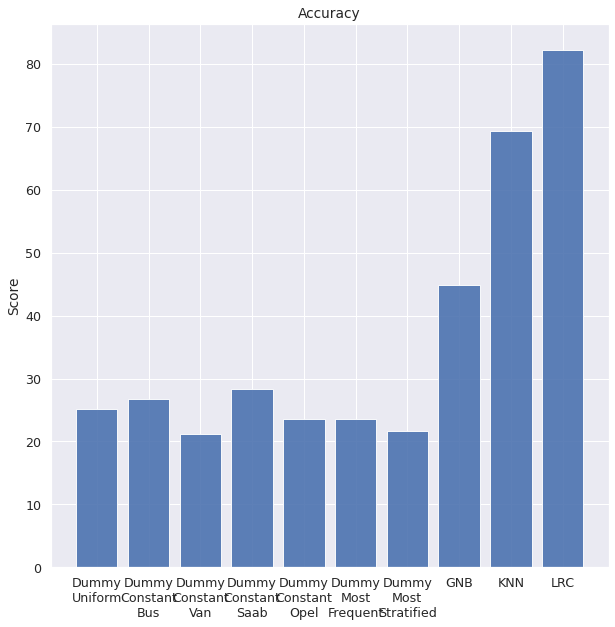

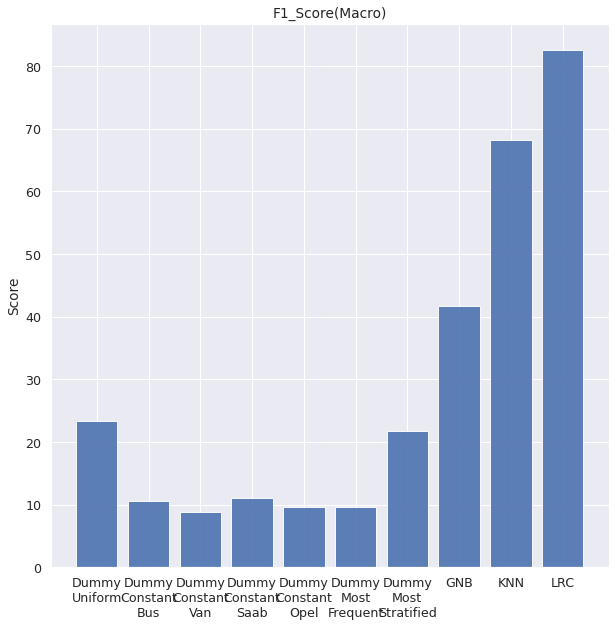

In [ ]:
classifiers = ('Dummy\nUniform', 'Dummy\nConstant\nBus', 'Dummy\nConstant\nVan', 'Dummy\nConstant\nSaab', 'Dummy\nConstant\nOpel', 'Dummy\nMost\nFrequent', 'Dummy\nMost\nStratified', 'GNB', 'KNN', 'LRC')
f = plt.figure(1)
f.set_figwidth(10)
f.set_figheight(10)
y_pos = np.arange(len(classifiers))
plt.bar(y_pos, classifiers_accuracy, align='center', alpha=0.9)
plt.xticks(y_pos, classifiers)
plt.ylabel('Score')
plt.title("Accuracy")
plt.show()

f = plt.figure(1)
f.set_figwidth(10)
f.set_figheight(10)
y_pos = np.arange(len(classifiers))
plt.bar(y_pos, classifiers_f1_score, align='center', alpha=0.9)
plt.xticks(y_pos, classifiers)
plt.ylabel('Score')
plt.title("F1_Score(Macro)")
plt.show()


| Estimator                       | Accuracy (%) | F1 Metric(Macro) (%) |
| :-------------------------:     |:-----------: | :-----------: |
| Dummy_Uniform | 25.2 | 23.3|
| Dummy_Const Bus | 26.8 | 10.6 |
| Dummy_Const Van | 21.3 | 8.8 |
| Dummy_Const Saab | 28.3 | 11 |
| Dummy_Const Opel | 23.6 | 9.6 |
| Most_Frequent | 23.6 | 9.6 |
| Stratified | 21.7 | 21.9 |
| GaussianNB | 44.9 | 41.67 |
| KNN | 69.3 | 68.2 | 
| LRC | 82.3 | 82.64 |

(Σημείωση: Επειδή ο κώδικας μπορεί να έχει τρέξει ξανά, ενδέχεται τα αποτελέσματα να διαφέρουν ελαφρώς από τον πίνακα)

**Σχολιασμός αποτελεσμάτων με βάση το Out-of-the-box**

Παρατηρούμε πως την καλύτερη επίδοση την έχει ο LRC με accuracy και F1 (macro) κοντά στο 82%, ενώ και ο ΚΝΝ σημειώνει καλές επιδόσεις με accuracy και F1 κοντά στο 69%! Ωστόσο, περιμένουμε πως ο ΚΝΝ θα βελτιωθεί αρκετά όταν κάνουμε κανονικοποίηση στα δεδομένα, καθώς τώρα τα χαρακτηριστικά παρουσιάζουν ανομοιομορφία στην κλίμακα τους και επομένως ένα χαρακτηριστικό με μεγάλη απόσταση μπορεί να επηρεάζει κατά πολύ την επιλογή της κλάσης. 

O GNB παρουσιάζει καλύτερες επιδόσεις από τους Dummy Classifiers, ωστόσο γενικά παρουσιάζει μέτρια επίδοση γύρω στο 40%, καθώς τα δεδομένα είναι έντονα εξαρτημένα το ένα με το άλλο, ενώ ο GNB υποθέτει πως τα χαρακτηριστικά είναι ανεξάρτητα

Οι Dummy Classifiers προφανώς έχουν κακή επίδοση αφού κάνουν τυχαίο classification, με καλύτερους τους Uniform και Stratified. O Uniform παρουσιάζει ίδια επίδοση με τον Stratified, γιατί το dataset είναι ισορροπημένο.

In [ ]:
def evaluate_classifier(clf, X, y, clf_name):
    accuracy = cross_val_score(clf, X, y, 
    cv=KFold(n_splits=10, random_state=None),scoring="accuracy")*100
    f1_macro = cross_val_score(clf, X, y, 
    cv=KFold(n_splits=10, random_state=None),scoring="f1_macro")*100
    print(clf_name, "accuracy:", np.mean(accuracy), "%")
    print(clf_name, "f1_macro:", np.mean(f1_macro), "%")

evaluate_classifier(KNC, X_train, y_train, "Uniform")

Uniform accuracy: 60.48870056497175 %
Uniform f1_macro: 58.10406685321509 %


#**Βελτιστοποίηση**


Επιλέγουμε να δημιουργήσουμε ένα pipeline με σκοπό την βελτιστοποίηση των ταξινομητών. Στη συνέχεια, με χρήση GridSearch, θα αναζητήσουμε τις βέλτιστες τιμές των υπερπαραμέτρων των ταξινομητών και μετασχηματιστών του pipe. 

Επιλέγουμε να χρησιμοποιήσουμε Scaler, καθώς τα δεδομένα μας δεν είναι κανονικοποιημένα. Επίσης, επιλέγουμε selector, καθώς υπάρχουν κάποια χαρακτηριστικά με αρκετά χαμηλό variance. Επιλέγουμε μετασχηματιστή PCA, για να μειώσουμε τον αριθμό των χαρακτηριστικών και τέλος χρησιμοποιούμε και Random Under Sampler, αφού παρατηρούμε πως υπάρχει μια μικρή ανισορροπία στον αριθμό των Van (είναι σχετικά λιγότερα)

In [ ]:
selector = VarianceThreshold()
scaler = StandardScaler()
pca = PCA()
ros = RandomUnderSampler()

train_variance = X_train.var(axis=0)
print(sorted(train_variance))
print(np.max(train_variance))

opt_acc = []
opt_f1 = []

[6.5083517850620645, 19.17126723429527, 23.376480893900627, 36.96428734477722, 37.83678494795471, 47.09071402483572, 53.26890065741407, 56.38912698593859, 59.76513136869978, 65.10340291727547, 78.35458991508412, 205.3659491417094, 239.7788503241424, 934.0557632167652, 1030.8571493791073, 1062.7918388193946, 1074.7275840029213, 30369.14949038986]
30369.14949038986


##**Gaussian Naive-Bayes**

In [ ]:
clf =  GaussianNB() 
pipe = Pipeline(steps=[('sampler', ros), ('pca', pca), ('gnb', clf)], memory='tmp')

In [ ]:
pipe.fit(X_train,y_train)
predsgnb = pipe.predict(X_test)
print(classification_report(y_test, predsgnb))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93        68
           1       0.81      1.00      0.89        54
           2       0.69      0.64      0.66        72
           3       0.64      0.63      0.64        60

    accuracy                           0.78       254
   macro avg       0.78      0.79      0.78       254
weighted avg       0.78      0.78      0.78       254



In [ ]:
vthreshold = [1, 10] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
n_components = [10, 12, 15, 17, 18]
var_thresh = [10e-7, 10e-5, 10e-4, 10e-2]


In [ ]:
estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, gnb__var_smoothing=var_thresh),error_score='raise', cv=10, scoring='f1_macro', n_jobs=-1)

start_time = time.time()
estimator.fit(X_train, y_train)
preds = estimator.predict(X_test)
#print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92        68
           1       0.82      1.00      0.90        54
           2       0.69      0.65      0.67        72
           3       0.65      0.65      0.65        60

    accuracy                           0.78       254
   macro avg       0.79      0.79      0.79       254
weighted avg       0.79      0.78      0.78       254



In [ ]:
print(estimator.best_estimator_)
print(estimator.best_params_)

Pipeline(memory='tmp',
         steps=[('sampler', RandomUnderSampler()),
                ('pca', PCA(n_components=18)),
                ('gnb', GaussianNB(var_smoothing=1e-06))])
{'gnb__var_smoothing': 1e-06, 'pca__n_components': 18}


In [ ]:
clf = GaussianNB(var_smoothing=10e-6)
pca1 = PCA(n_components=18)
pipe = Pipeline(steps=[('sampler', ros), ('pca', pca1), ('gnb', clf)], memory='tmp')
start_time = time.time()
pipe.fit(X_train,y_train)
print("Συνολικός χρόνος fit του καλύτερου μοντέλου: %s seconds" % (time.time() - start_time))
start_time = time.time()
preds = pipe.predict(X_test)
print("Συνολικός χρόνος predict του καλύτερου μοντέλου: %s seconds" % (time.time() - start_time))
opt_acc.append(pipe.score(X_test,y_test)*100)
opt_f1.append(f1_score(y_test, preds, average = "macro")*100)
print(classification_report(y_test, preds))

Συνολικός χρόνος fit του καλύτερου μοντέλου: 0.13689255714416504 seconds
Συνολικός χρόνος predict του καλύτερου μοντέλου: 0.00803995132446289 seconds
              precision    recall  f1-score   support

           0       0.98      0.87      0.92        68
           1       0.79      1.00      0.89        54
           2       0.69      0.68      0.69        72
           3       0.67      0.62      0.64        60

    accuracy                           0.78       254
   macro avg       0.79      0.79      0.78       254
weighted avg       0.79      0.78      0.78       254



##**KNN**


In [ ]:
clf = KNeighborsClassifier(n_jobs=-1) 
pipe = Pipeline(steps=[('scaler', scaler),('kNN', clf)], memory='tmp')

In [ ]:
pipe.fit(X_train,y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        68
           1       0.78      0.87      0.82        54
           2       0.63      0.61      0.62        72
           3       0.56      0.48      0.52        60

    accuracy                           0.73       254
   macro avg       0.72      0.73      0.73       254
weighted avg       0.72      0.73      0.73       254



In [ ]:
vthreshold = [1, 10, 14] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
n_components = [15, 17, 18]
k = [1,2,4,5] # η υπερπαράμετρος του ταξινομητή

In [ ]:
estimator = GridSearchCV(pipe, dict(kNN__n_neighbors=k), cv=10, scoring='f1_macro', n_jobs=-1)

start_time = time.time()
estimator.fit(X_train, y_train)
preds = estimator.predict(X_test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, preds))

Συνολικός χρόνος fit και predict: 3.536184787750244 seconds
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        68
           1       0.78      0.87      0.82        54
           2       0.63      0.61      0.62        72
           3       0.56      0.48      0.52        60

    accuracy                           0.73       254
   macro avg       0.72      0.73      0.73       254
weighted avg       0.72      0.73      0.73       254



In [ ]:
print(estimator.best_estimator_)
print(estimator.best_params_)

Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('kNN', KNeighborsClassifier(n_jobs=-1))])
{'kNN__n_neighbors': 5}


In [ ]:
clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
pca2 = PCA(n_components=17)
pipe = Pipeline(steps=[('scaler', scaler),('gnb', clf)], memory='tmp')
start_time = time.time()
pipe.fit(X_train,y_train)
print("Συνολικός χρόνος fit του καλύτερου μοντέλου: %s seconds" % (time.time() - start_time))
start_time = time.time()
preds = pipe.predict(X_test)
print("Συνολικός χρόνος predict του καλύτερου μοντέλου: %s seconds" % (time.time() - start_time))
opt_acc.append(pipe.score(X_test,y_test)*100)
opt_f1.append(f1_score(y_test, preds, average = "macro")*100)
print(classification_report(y_test, preds))

Συνολικός χρόνος fit του καλύτερου μοντέλου: 0.08427000045776367 seconds
Συνολικός χρόνος predict του καλύτερου μοντέλου: 0.12602591514587402 seconds
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        68
           1       0.78      0.87      0.82        54
           2       0.63      0.61      0.62        72
           3       0.56      0.48      0.52        60

    accuracy                           0.73       254
   macro avg       0.72      0.73      0.73       254
weighted avg       0.72      0.73      0.73       254



##**Logistic Regression**

In [ ]:
clf = LogisticRegression(max_iter=10000 , n_jobs=-1) 
pipe = Pipeline(steps=[('sampler', ros), ('pca', pca), ('lrc', clf)], memory='tmp')
pipe.fit(X_train,y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        68
           1       0.95      1.00      0.97        54
           2       0.70      0.68      0.69        72
           3       0.67      0.70      0.68        60

    accuracy                           0.82       254
   macro avg       0.82      0.83      0.83       254
weighted avg       0.82      0.82      0.82       254



In [ ]:
vthreshold = [1, 10, 24] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
n_components = [13, 15, 17]
solvers = ['lbfgs', 'liblinear', 'saga']
c_val = [0.1, 10, 50]

In [ ]:
estimator = GridSearchCV(pipe, dict(pca__n_components=n_components, lrc__solver = solvers), cv=10, scoring='f1_macro', n_jobs=-1)

start_time = time.time()
estimator.fit(X_train, y_train)
preds = estimator.predict(X_test)
print("Συνολικός χρόνος fit και predict: %s seconds" % (time.time() - start_time))
print(classification_report(y_test, preds))

Συνολικός χρόνος fit και predict: 104.71891403198242 seconds
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        68
           1       0.95      1.00      0.97        54
           2       0.71      0.71      0.71        72
           3       0.69      0.70      0.69        60

    accuracy                           0.83       254
   macro avg       0.83      0.83      0.83       254
weighted avg       0.83      0.83      0.83       254



In [ ]:
print(estimator.best_estimator_)
print(estimator.best_params_)

Pipeline(memory='tmp',
         steps=[('sampler', RandomUnderSampler()),
                ('pca', PCA(n_components=17)),
                ('lrc', LogisticRegression(max_iter=10000, n_jobs=-1))])
{'lrc__solver': 'lbfgs', 'pca__n_components': 17}


In [ ]:
clf = LogisticRegression(max_iter=1000 , n_jobs=-1, solver='lbfgs') 
pca3 = PCA(n_components=17)
pipe = Pipeline(steps=[('sampler', ros), ('pca', pca3), ('gnb', clf)], memory='tmp')
start_time = time.time()
pipe.fit(X_train,y_train)
print("Συνολικός χρόνος fit του καλύτερου μοντέλου: %s seconds" % (time.time() - start_time))
start_time = time.time()
preds = pipe.predict(X_test)
print("Συνολικός χρόνος predict του καλύτερου μοντέλου: %s seconds" % (time.time() - start_time))
opt_acc.append(pipe.score(X_test,y_test)*100)
opt_f1.append(f1_score(y_test, preds, average = "macro")*100)
print(classification_report(y_test, preds))

Συνολικός χρόνος fit του καλύτερου μοντέλου: 1.042888879776001 seconds
Συνολικός χρόνος predict του καλύτερου μοντέλου: 0.0016331672668457031 seconds
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        68
           1       0.96      0.98      0.97        54
           2       0.71      0.71      0.71        72
           3       0.69      0.72      0.70        60

    accuracy                           0.83       254
   macro avg       0.84      0.84      0.84       254
weighted avg       0.83      0.83      0.83       254



##**Αποτελέσματα και Συμπεράσματα**

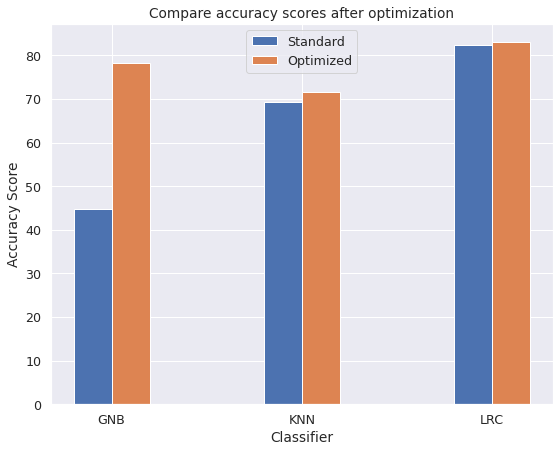

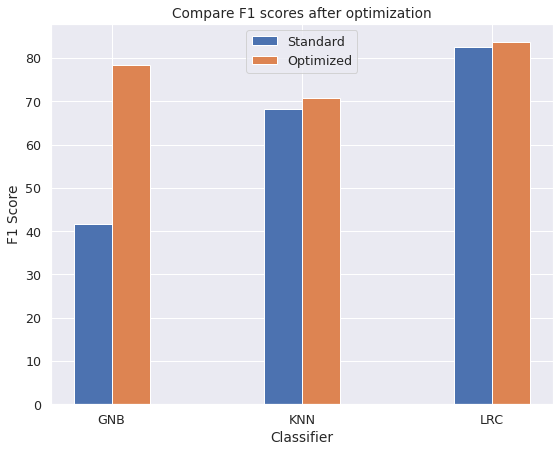

In [ ]:
classifiers = ['GNB', 'KNN', 'LRC']
fig, ax = plt.subplots(figsize=(9,7))
y_pos = np.arange(len(classifiers))
bar_width = 0.2
acc_old = ax.bar(y_pos, classifiers_accuracy[-3:], bar_width, label="Standard")

acc_opt = ax.bar(y_pos + bar_width, opt_acc, bar_width, label="Optimized")

ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy Score')
ax.set_title('Compare accuracy scores after optimization')
ax.set_xticklabels(classifiers)
ax.set_xticks(y_pos + bar_width / 2)
ax.legend()
plt.show()



fig, ax = plt.subplots(figsize=(9,7))
y_pos = np.arange(len(classifiers))
bar_width = 0.2
acc_old = ax.bar(y_pos, classifiers_f1_score[-3:], bar_width, label="Standard")

acc_opt = ax.bar(y_pos + bar_width, opt_f1, bar_width, label="Optimized")

ax.set_xlabel('Classifier')
ax.set_ylabel('F1 Score')
ax.set_title('Compare F1 scores after optimization')
ax.set_xticklabels(classifiers)
ax.set_xticks(y_pos + bar_width / 2)
ax.legend()
plt.show()


| Estimator                       | Accuracy (%) | F1 Metric(Macro) (%) | Increased By (%) | Time of fit (s) | Time of predict (s) |
| :-------------------------:     |:-----------: | :-----------: | :-----------: | :-----------: | :-----------: |
| GaussianNB | 78 | 78 | 36 | 0.12 | 0.002 |
| KNN | 73 | 73 | 4.8 | 0.04 | 0.11 |
| LRC | 83 | 84 | 1.3 | 1.2 | 0.0014 |

(Σημείωση: Επειδή ο κώδικας μπορεί να έχει τρέξει ξανά, ενδέχεται τα αποτελέσματα να διαφέρουν ελαφρώς από τον πίνακα)

Σε γενικές γραμμές το Dataset θα χαρακτηριζόταν ως "δύσκολο". Οι επιδόσεις δεν είναι πολύ καλές και φαίνεται πως ειδικά για τους ταξινομητές GNB, KNN μεγιστοποιούνται στο 75-80%. Αυτό μπορεί να διασταυρωθεί και με αντίστοιχη βιβλιογραφία: https://www.sciencedirect.com/science/article/pii/S0957417415008143

**Για τον GNB:**

Αρχικά είχαμε F1 macro και Accuracy της τάξης του 45%. Η χαμηλή επίδοση οφείλεται κυρίως στην συσχέτιση που "κρύβεται" πίσω από τα χαρακτηριστικά του συγκεκριμένου dataset. Γι' αυτό λοιπόν εδώ χρησιμοποιώντας PCA όταν μειώνονται οι διαστάσεις παίρνουμε πολύ καλύτερες επιδόσεις που αγγίζουν μέχρι και το 78%. Ο PCA δημιουργεί components που δεν είναι στενά συσχετισμένα μεταξύ τους και επομένως βελτιώνει κατά πολύ την επίδοση. Επίσης, με τη χρήση του Random Under Sampler βελτιώνουμε την μικρή ανισορροπία που υπάρχει στα δείγματα και βελτιώνουμε λίγο ακόμα την επίδοση. Ο scaler και ο selector δοκιμάστηκαν σε διάφορους συνδυασμούς και παρατηρήθηκε πως δεν βελτιώνουν την επίδοση για τον GNB. Τέλος, με Grid Search αναζητούμε τις βέλτιστες υπερπαραμέτρους για το GNB και το PCA (var smoothing = 10^-6 και n_components = 18), αλλά επειδή η επίδοση έχει ήδη φτάσει σε τοπικό μέγιστο οι βέλτιστες τιμές των υπερπαραμέτρων είναι πολύ κοντά στις default και δεν βελτιώνουν την επίδοση περαιτέρω. 

**Για τον KNN:**

Αρχικά είχαμε F1 macro και Accuracy της τάξης του 68-69%, η οποία είναι καλή επίδοση για το δεδομένο dataset. Ωστόσο, επειδή τα δεδομένα καταλαμβάνουν ένα μεγάλο εύρος τιμών και δεν είναι κανονικοποιήμενα (όπως εξηγήθηκε και παραπάνω) οδηγούν τον ταξινομητή σε λανθασμένες επιλογές. Επομένως χρησιμοποιώντας ένα pipe με έναν Standard Scaler κανονικοποιούμε τα δεδομένα και έτσι πετυχαίνουμε επίδοση 73% Οι υπόλοιπο μετασχηματιστές δοκιμάστηκαν και διαπιστώθηκε πως για τον KNN δεν βελτιώνουν την επίδοση. Τέλος, με Grid Search αναζητούμε τις βέλτιστες υπερπαραμέτρους, δηλαδή το βέλτιστο k. Στην αρχή με μεγάλο εύρος παρατηρήσαμε ότι πάντα τείνει να έχει καλύτερη επίδοση για σχετικά μικρά k και τελικά την καλύτερη επίδοση την έχει το k=5 που είναι και η default τιμή, επομένως η επίδοση δεν βελτιώνεται παραπάνω από το 73%.

**Για τον LRC:**

Εξ' αρχής ο LRC πετύχαινε αρκετά υψηλή επίδοση της τάξης του 82% και ξεπερνούσε κατά πολύ τους υπόλοιπους. Γενικότερα ο LRC βελτιώνεται με καλό data preprocessing. Εφόσον το dataset είναι ήδη αρκετά ισορροπημένο και δεν έχει απουσιάζουσες τιμές ο LRC πετυχαίνει πολύ υψηλές επιδόσεις για το δεδομένο dataset. Στη συνέχεια, με τη χρήση Random Under Sampler βελτιώνουμε την μικρή ανισορροπία στα δείγματα και μαζί με PCA ο LRC πετυχαίνει επίδοσεις της τάξης του 83%. Ο PCA, αφού μειώνει την συσχέτιση μεταξύ των χαρακτηριστικών βελτιώνει και αυτός την επίδοση του LRC. Οι υπόλοιποι μετασχηματιστές δοκιμάστηκαν σε εύρος συνδυασμών με Grid Search και δεν βελτιώνουν περαιτέρω τον LRC. Αναζητώντας τις βέλτιστες υπερπαραμέτρους είδαμε πως το PCA δίνει την καλύτερη επίδοση για n_components = 17 και ο καλύτερος solver για τον LRC είναι ο lbfgs που είναι κατάλληλος για μικρά datasets. Επίσης, η βέλτιστη τιμή της υπερπαραμέτρου C προκύπτει να είναι η default = 1.0 (στο κελί του Grid Search δεν έχει συμπεριληφθεί γιατί καθυστερεί το τρέξιμο και έχει ήδη διαπιστωθεί πως η βέλτιστη είναι 1.0 από προηγούμενα τρεξίματα). Με τις βέλτιστες υπερπαραμέτρους βελτιώνουμε λίγο τον LRC φτάνοντας το 84% F1 macro. Επίσης, με χρήση Pipe παρατηρούμε πως ο LRC εκπαιδεύεται πιο γρήγορα σε σχέση με πριν.

Confusion Matrix of Logistic Regression:


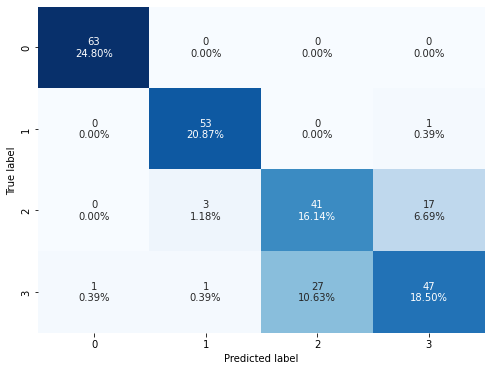

In [ ]:
from sklearn.metrics import confusion_matrix
pca = PCA(n_components=17)
ros = RandomUnderSampler()
scaler = StandardScaler()

clf = LogisticRegression(max_iter=10000 , n_jobs=-1) 
pipe = Pipeline(steps=[('sampler', ros), ('pca', pca), ('lrc', clf)], memory='tmp')
pipe.fit(X_train,y_train)
preds = pipe.predict(X_test)

print("Confusion Matrix of Logistic Regression:")
cf_matrix = confusion_matrix(y_test, preds)
make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False)

Confusion Matrix of KNN:


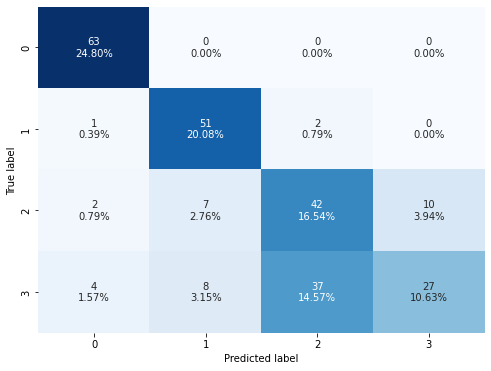

In [ ]:
clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=5)
pipe = Pipeline(steps=[('scaler', scaler),('gnb', clf)], memory='tmp')
pipe.fit(X_train,y_train)
preds = pipe.predict(X_test)

print("Confusion Matrix of KNN:")
cf_matrix = confusion_matrix(y_test, preds)
make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False)

**Σχολιασμός:**

Παρατηρούμε πως οι ταξινομητές δεν κατατάσσουν σωστά τα saab και τα opel οχήματα. Ωστόσο, ο LRC καταφέρνει καλύτερα να κατατάξει τα συγκεκριμένα οχήματα στις σωστές κλάσεις, σε αντίθεση με τον ΚΝΝ ο οποίος επειδή χρησιμοποιεί απλά την ευκλίδεια απόσταση των χαρακτηριστικών βάζει πολλά οχήματα τύπου opel στην κατηγορία saab. 

**Συμπέρασμα:**

Τελικά, θα προτείναμε τον ταξινομητή Logistic Regression για το συγκεκριμένο dataset. Το μοναδικό του μειονέκτημα είναι πως είναι πιο αργός στο fit σε σχέση με τους άλλους, ωστόσο πετυχαίνει πολύ καλύτερες επιδόσεις. 

Στη συγκεκριμένη περίπτωση τα δεδομένα είναι γραμμικά διαχωρίσιμα, πράγμα που ευνοεί τον LRC. Σε σχέση με τον GNB, ωστόσο, που είναι ο 2ος καλύτερος σε επιδόσεις, ο LRC δεν υποθέτει πως τα χαρακτηριστικά είναι ανεξάρτητα μεταξύ τους, αλλά υπολογίζει την θετική ή αρνητική συσχέτιση μεταξύ των χαρακτηριστικών και τα διαχωρίζει με γραμμικό τρόπο. Επίσης, αποφεύγει το overfitting στα δεδομένα.